In [32]:
# Importation des bibliothèques nécessaires
import pandas as pd  # Pour la manipulation et l'analyse des données
import numpy as np  # Pour les opérations numériques et les calculs
from sklearn.ensemble import RandomForestClassifier  # Pour l'algorithme de classification
from sklearn.metrics import precision_score  # Pour évaluer la précision du modèle
from sklearn.preprocessing import StandardScaler  # Pour normaliser les données
import matplotlib.pyplot as plt  # Pour la visualisation des données
from sklearn.utils import resample  # Pour le rééchantillonnage des données

In [35]:
import ta as TA  # Pour les indicateurs techniques utilisés dans l'analyse financière

In [36]:
# Liste des symboles boursiers classés par secteurs
stock_symbol_list = [
    "KO", "PEP", "MDLZ", "TSN", "ADM",  # Agroalimentaire
    "MET", "PRU", "AFL", "AIG", "ALL",  # Assurance
    "DIS", "NFLX", "CMCSA", "LYV", "FOXA",  # Divertissement
    "WMT", "AMZN", "TGT", "COST", "HD",  # Distribution
    "XOM", "CVX",  "BP",  # Énergie
    "AAPL", "MSFT", "GOOGL", "NVDA", "TSLA",  # Technologie
    "PFE", "MRK", "GSK", "NVS", "ABBV",  # Pharmaceutique
    "MMM", "HON", "GE", "CAT", "BA",  # Industriel
    "NKE", "LULU", "PVH", "GPS", "FL",  # Mode
    "NKE", "UAA", "ADDYY", "DIS", "DKNG",  # Sport
    "T", "VZ", "TMUS",   # Télécommunication
    "CRM", "BABA", "SQ", "PYPL", "MELI"  # Business
]

Précision du modèle : 0.5825396825396826


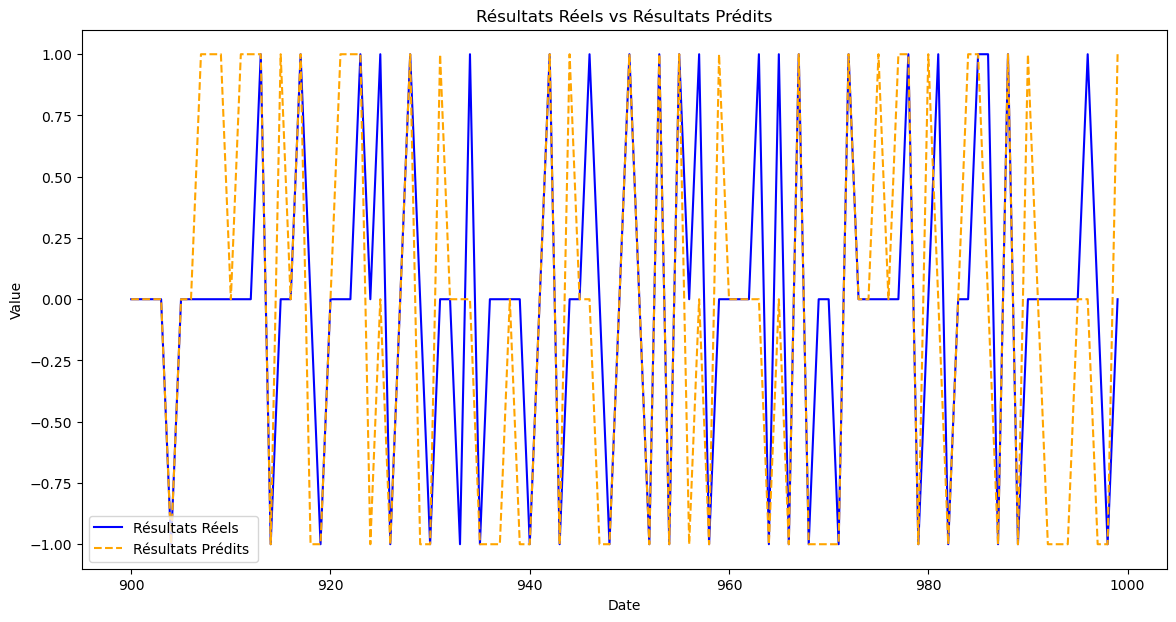

In [37]:
# Simulation de données de stock, à remplacer par le chargement de données réelles
stock_data_list = [pd.DataFrame({
    'Close': np.random.rand(1000) * 100,
    'Volume': np.random.rand(1000) * 10000,
    'Open': np.random.rand(1000) * 100,
    'High': np.random.rand(1000) * 100,
    'Low': np.random.rand(1000) * 100
}) for _ in stock_symbol_list]

# Création de la colonne Target
for L in stock_data_list:
    L['Target'] = np.log(L['Close'] / L['Close'].shift(-1)) * 100
    
    # Calcul des quantiles
    quantile_20 = L['Target'].quantile(0.2)
    quantile_80 = L['Target'].quantile(0.8)
    
    # Conditions pour définir les cibles
    conditions = [
        (L['Target'] > quantile_80),
        (L['Target'] < quantile_20),
    ]
    
    # Valeurs associées aux conditions
    values = [1, -1]
    L['Target'] = np.select(conditions, values, default=0)

# Combiner toutes les données en un seul DataFrame
combined_data = pd.concat(stock_data_list)

# Définir les prédicteurs
predictors = ["Close", "Volume", "Open", "High", "Low"]

# Séparer les données en ensembles d'entraînement et de test
train = combined_data.iloc[:-100].copy()
test = combined_data.iloc[-100:].copy()

# Gérer le déséquilibre des classes avec le rééchantillonnage
train_majority = train[train.Target == 0]
train_minority_pos = train[train.Target == 1]
train_minority_neg = train[train.Target == -1]

train_minority_pos_upsampled = resample(train_minority_pos,
                                        replace=True,     # échantillonner avec remplacement
                                        n_samples=len(train_majority),    # pour correspondre à la classe majoritaire
                                        random_state=123) # résultats reproductibles

train_minority_neg_upsampled = resample(train_minority_neg,
                                        replace=True,     # échantillonner avec remplacement
                                        n_samples=len(train_majority),    # pour correspondre à la classe majoritaire
                                        random_state=123) # résultats reproductibles

train_upsampled = pd.concat([train_majority, train_minority_pos_upsampled, train_minority_neg_upsampled])

# Normaliser les données
scaler = StandardScaler()
train_upsampled.loc[:, predictors] = scaler.fit_transform(train_upsampled[predictors])
test.loc[:, predictors] = scaler.transform(test[predictors])

# Définir et entraîner le modèle
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
model.fit(train_upsampled[predictors], train_upsampled["Target"])

# Prédire les résultats sur les données de test
preds = model.predict(test[predictors])

# Calculer la précision du modèle
precision = precision_score(test["Target"], preds, average='macro', zero_division=0)
print(f"Précision du modèle : {precision}")

# Convertir les prédictions en une série Pandas pour une manipulation facile
preds = pd.Series(preds, index=test.index)

# Combiner les prédictions et les valeurs réelles pour la comparaison
combined = pd.concat([test["Target"], preds], axis=1)
combined.columns = ['Actual', 'Predicted']

# Afficher les résultats
plt.figure(figsize=(14, 7))
plt.plot(combined.index, combined['Actual'], label='Résultats Réels', color='blue')
plt.plot(combined.index, combined['Predicted'], label='Résultats Prédits', color='orange', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.title("Résultats Réels vs Résultats Prédits")
plt.legend()
plt.show()

In [38]:
# Définir les prédicteurs
predictors = ["Close", "Volume", "Open", "High", "Low"]

# Définir et entraîner le modèle
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Fonction de backtesting
def backtest(stock_data_list, model, predictors, start=500, step=100):
    all_predictions = []  # Liste pour stocker toutes les prédictions
    for stock_data in stock_data_list:
        for i in range(start, stock_data.shape[0], step):
            train = stock_data.iloc[0:i].copy()  # Données d'entraînement
            test = stock_data.iloc[i:(i + step)].copy()  # Données de test

            # Gestion du déséquilibre des classes par rééchantillonnage
            train_majority = train[train.Target == 0]
            train_minority_pos = train[train.Target == 1]
            train_minority_neg = train[train.Target == -1]

            train_minority_pos_upsampled = resample(train_minority_pos, replace=True, n_samples=len(train_majority), random_state=123)
            train_minority_neg_upsampled = resample(train_minority_neg, replace=True, n_samples=len(train_majority), random_state=123)

            train_upsampled = pd.concat([train_majority, train_minority_pos_upsampled, train_minority_neg_upsampled])

            # Normaliser les données
            scaler = StandardScaler()
            train_upsampled.loc[:, predictors] = scaler.fit_transform(train_upsampled[predictors])
            test.loc[:, predictors] = scaler.transform(test[predictors])

            # Vérifier la taille des ensembles d'entraînement et de test
            if len(train_upsampled) < 10 or len(test) < 10:
                continue

            # Entraîner le modèle
            model.fit(train_upsampled[predictors], train_upsampled["Target"])

            # Prédire les résultats
            preds = model.predict(test[predictors])
            preds = pd.Series(preds, index=test.index, name="Predictions")
            combined = pd.concat([test["Target"], preds], axis=1)
            all_predictions.append(combined)
    
    if len(all_predictions) == 0:
        print("Aucune donnée valide pour le backtesting")
        return None
    
    return pd.concat(all_predictions)

# Exécuter le backtesting
backtest_results = backtest(stock_data_list, model, predictors, start=100, step=50)
if backtest_results is not None:
    print("Résultats du backtesting obtenus avec succès.")
    # Calculer le score de précision
    precision = precision_score(backtest_results["Target"], backtest_results["Predictions"], average='macro', zero_division=0)
    print("Score de précision :", precision)

Backtesting results obtained successfully.
Precision score: 0.5548776046726657


In [41]:
# Importation des bibliothèques nécessaires
from finta import TA  # Pour les indicateurs techniques utilisés dans l'analyse financière
import tensorflow as tf  # Pour la construction et l'entraînement de modèles de deep learning
import numpy as np  # Pour les opérations numériques et les calculs
from sklearn.preprocessing import MinMaxScaler  # Pour normaliser les données sur une échelle de 0 à 1

In [42]:
# Taille de la fenêtre pour les calculs basés sur la fenêtre
window_size = 100

# Calcul de la volatilité historique
L['Volatilité'] = L['Close'].rolling(window=window_size).std()

# Calcul du TRIX (Triple Exponential Moving Average)
def calculate_TRIX(data, window_size):
    ema_1 = data['Close'].ewm(span=window_size, adjust=False).mean()
    ema_2 = ema_1.ewm(span=window_size, adjust=False).mean()
    ema_3 = ema_2.ewm(span=window_size, adjust=False).mean()
    trix = (ema_3 - ema_3.shift(1)) / ema_3.shift(1) * 100
    return trix

L["TRIX"] = calculate_TRIX(L, window_size)

# Utilisation de numpy.select pour attribuer les valeurs en fonction des conditions
L["SMA"] = TA.SMA(L, 100)  # Moyenne mobile simple sur 100 jours
L["RSI"] = TA.RSI(L)  # Indice de force relative
L["EMA"] = L["Close"].ewm(span=20, adjust=False).mean()  # Moyenne mobile exponentielle sur 20 jours
L["Momentum"] = L["Close"].diff(periods=10)  # Momentum sur 10 jours
L["Stochastic_Oscillator"] = (L["Close"] - L["Low"].rolling(window=14).min()) / (
        L["High"].rolling(window=14).max() - L["Low"].rolling(window=14).min())  # Oscillateur stochastique

# Normalisation des indicateurs
L['Volatilité_n'] = L['Volatilité'] / L['Volatilité'].max()
L["SMA_n"] = L["SMA"] / L["SMA"].max()
L["RSI_n"] = L["RSI"] / L["RSI"].max()
L["EMA_n"] = L["EMA"] / L["EMA"].max()
L["Momentum_n"] = L["Momentum"] / L["Momentum"].max()
L["Stochastic_Oscillator_n"] = L["Stochastic_Oscillator"] / L["Stochastic_Oscillator"].max()
L["TRIX_n"] = L["TRIX"] / L["TRIX"].max()

In [43]:
combined_data = pd.concat(stock_data_list)
print(combined_data)

         Close       Volume       Open       High        Low  Target  \
0    31.245053  3412.666037  87.074754  79.987551  97.190140      -1   
1    80.117652  9522.916839   4.481476  86.815739  64.014916       0   
2    50.991256  6993.255001   5.496183  27.342540  17.366623       1   
3    13.264989   586.787150  23.585737  54.581814  99.156223      -1   
4    90.800000  3509.188857  31.404438  79.115711  11.917605       1   
..         ...          ...        ...        ...        ...     ...   
995  57.302171   406.649835  75.335180  66.568278   6.475095       0   
996  72.936289  1767.790670  32.056027  54.325894   4.823201       1   
997  16.353112  2815.329704  80.378126  47.662795   3.081962       0   
998  25.426569  7309.449364  89.204202  31.112517   2.191648      -1   
999  81.041649  5936.154058  74.454927  72.098456   1.937253       0   

     Volatilité      TRIX        SMA        RSI        EMA   Momentum  \
0           NaN       NaN        NaN        NaN        NaN    

Précision du modèle : 0.49061784897025174


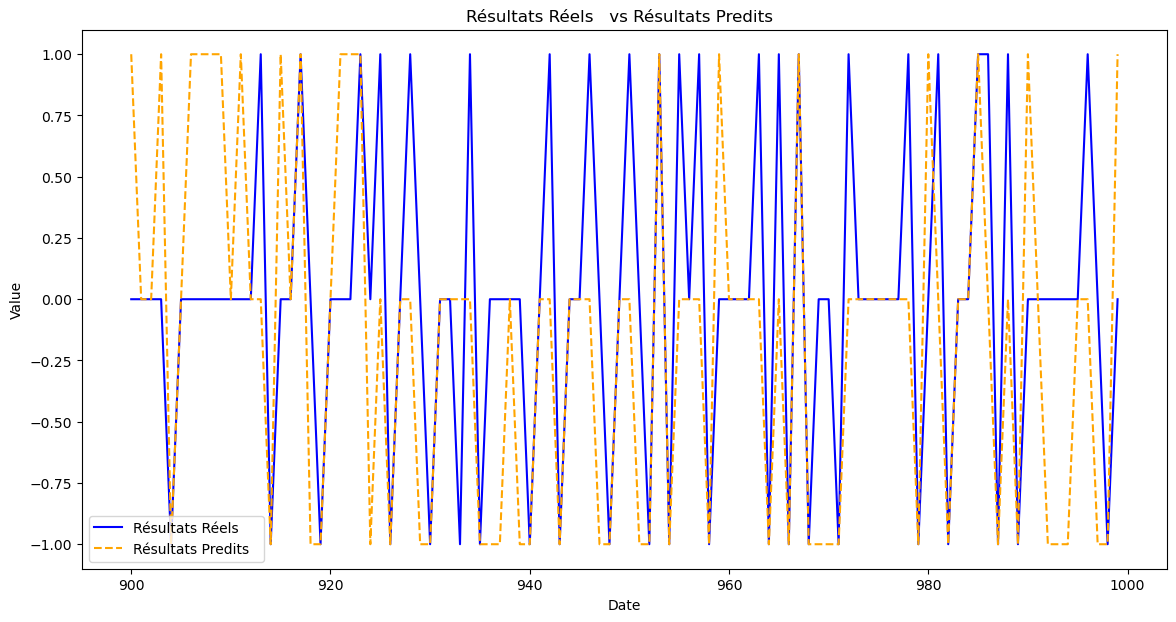

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Définir la liste des prédicteurs
predictors = ["Close", "Volume", "Open", "High", "Low", "Volatilité", "TRIX", "SMA", "RSI", "EMA", "Momentum", "Stochastic_Oscillator"]

# Séparer les données en ensembles d'entraînement et de test
train = combined_data.iloc[:-100].copy()
test = combined_data.iloc[-100:].copy()

# Gérer le déséquilibre des classes avec le rééchantillonnage
train_majority = train[train.Target == 0]
train_minority_pos = train[train.Target == 1]
train_minority_neg = train[train.Target == -1]

train_minority_pos_upsampled = resample(train_minority_pos,
                                        replace=True,
                                        n_samples=len(train_majority),
                                        random_state=123)

train_minority_neg_upsampled = resample(train_minority_neg,
                                        replace=True,
                                        n_samples=len(train_majority),
                                        random_state=123)

train_upsampled = pd.concat([train_majority, train_minority_pos_upsampled, train_minority_neg_upsampled])

# Imputer les valeurs manquantes avec la moyenne
imputer = SimpleImputer(strategy='mean')
train_upsampled_imputed = imputer.fit_transform(train_upsampled[predictors])
test_imputed = imputer.transform(test[predictors])

# Convertir le résultat en DataFrame
train_upsampled_imputed = pd.DataFrame(train_upsampled_imputed, columns=predictors)

# Normaliser les données
scaler = StandardScaler()
train_upsampled_imputed.loc[:, predictors] = scaler.fit_transform(train_upsampled_imputed[predictors])
test.loc[:, predictors] = scaler.transform(test[predictors])

# Définir et entraîner le modèle
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
model.fit(train_upsampled_imputed[predictors], train_upsampled["Target"])

# Prédire les résultats sur les données de test
preds = model.predict(test[predictors])

# Calculer la précision du modèle
precision = precision_score(test["Target"], preds, average='macro', zero_division=0)
print(f"Précision du modèle : {precision}")

# Convertir les prédictions en une série Pandas pour une manipulation facile
preds = pd.Series(preds, index=test.index)

# Combiner les prédictions et les valeurs réelles pour comparaison
combined = pd.concat([test["Target"], preds], axis=1)
combined.columns = ['Actual', 'Predicted']

# Afficher les résultats
plt.figure(figsize=(14, 7))
plt.plot(combined.index, combined['Actual'], label='Résultats Réels  ', color='blue')
plt.plot(combined.index, combined['Predicted'], label='Résultats Predits  ', color='orange', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Résultats Réels   vs Résultats Predits  ")
plt.legend()
plt.show()

In [45]:
combined_data = pd.concat(stock_data_list)

In [46]:
# Define predictors
predictors = ["Close", "Volume", "Open", "High", "Low", "Volatilité", "TRIX", "SMA", "RSI", "EMA", "Momentum", "Stochastic_Oscillator"]
# Define and train the model
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

def backtest(stock_data_list, model, predictors, start=500, step=100):
    all_predictions = []
    for stock_data in stock_data_list:
        for i in range(start, stock_data.shape[0], step):
            train = stock_data.iloc[0:i].copy()
            test = stock_data.iloc[i:(i + step)].copy()

            train_majority = train[train.Target == 0]
            train_minority_pos = train[train.Target == 1]
            train_minority_neg = train[train.Target == -1]

            train_minority_pos_upsampled = resample(train_minority_pos, replace=True, n_samples=len(train_majority), random_state=123)
            train_minority_neg_upsampled = resample(train_minority_neg, replace=True, n_samples=len(train_majority), random_state=123)

            train_upsampled = pd.concat([train_majority, train_minority_pos_upsampled, train_minority_neg_upsampled])

            scaler = StandardScaler()
            train_upsampled.loc[:, predictors] = scaler.fit_transform(train_upsampled[predictors])
            test.loc[:, predictors] = scaler.transform(test[predictors])

            if len(train_upsampled) < 10 or len(test) < 10:
                continue

            model.fit(train_upsampled[predictors], train_upsampled["Target"])

            preds = model.predict(test[predictors])
            preds = pd.Series(preds, index=test.index, name="Predictions")
            combined = pd.concat([test["Target"], preds], axis=1)
            all_predictions.append(combined)
    if len(all_predictions) == 0:
        print("No valid data for backtesting")
        return None
    return pd.concat(all_predictions)

# Backtest
backtest_results = backtest(stock_data_list, model, predictors, start=100, step=50)
if backtest_results is not None:
    print("Backtesting results obtained successfully.")
    # Calculate precision score
    precision = precision_score(backtest_results["Target"], backtest_results["Predictions"], average='macro', zero_division=0)
    print("Precision score:", precision)

KeyError: "['Volatilité', 'TRIX', 'SMA', 'RSI', 'EMA', 'Momentum', 'Stochastic_Oscillator'] not in index"